# ห้ามแก้ไฟล์นี้

# Results Structure

Extract `results.rar` to `/results` folder.

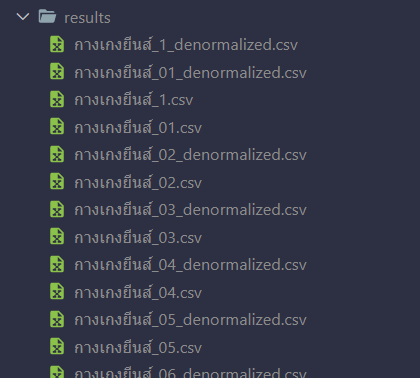

# Code

In [55]:
from os import listdir
from os.path import isfile, join
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
torch.cuda.is_available()

True

In [57]:
path = './results/'

In [58]:
files = [f for f in listdir(path) if isfile(join(path, f))]
files_denormalized = [f for f in files if "denormalized" in f]
files_normalized = [f for f in files if "denormalized" not in f]

In [59]:
mapping_file = './resources/Class_mapping.txt'
ctol = {}
ltoc = {}
with open(mapping_file) as f:
    for line in f:
        (key, val) = line.split()
        ctol[int(key)] = val
        ltoc[val] = int(key)

## Some data exploration

In [60]:
data = pd.read_csv(path + files_denormalized[0])

In [61]:
data = data.drop(['index'], axis=1)

# Dataset

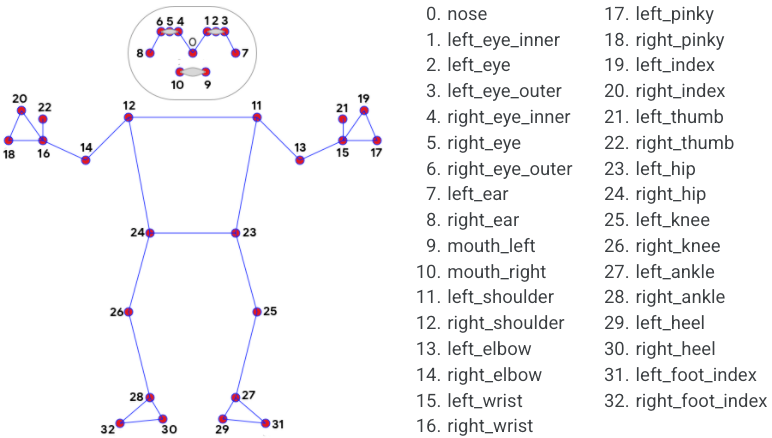
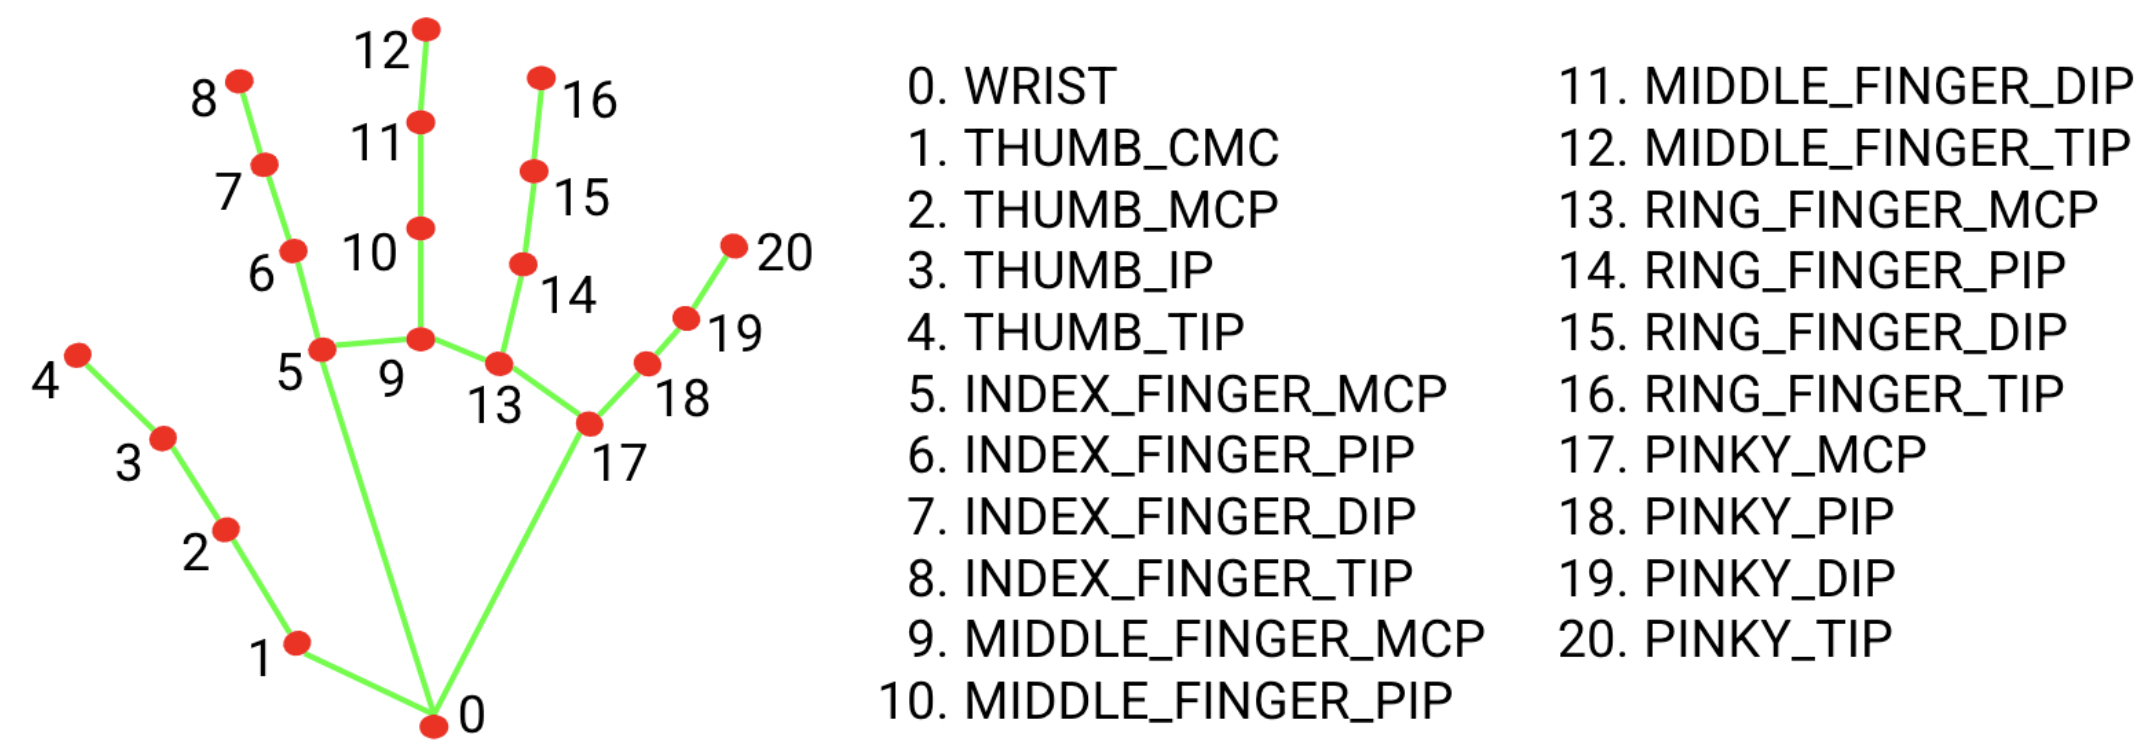

In [62]:
hand_index = np.array([0,1,4,5,8,9,12,13,16,17,20])
# pose_index = np.array([0,11, 12, 13, 14, 15, 16, 23, 24])
pose_index = np.array([0,11, 12])

In [63]:
col_name = []
hand_col_name = []
for pidx in pose_index:
    col_name.append('pose_' + str(pidx) + '_x')
    col_name.append('pose_' + str(pidx) + '_y')
for hidx in hand_index:
    col_name.append('left_hand_' + str(hidx) + '_x')
    col_name.append('left_hand_' + str(hidx) + '_y')
    hand_col_name.append('left_hand_' + str(hidx) + '_x')
    hand_col_name.append('left_hand_' + str(hidx) + '_y')
for hidx in hand_index:
    col_name.append('right_hand_' + str(hidx) + '_x')
    col_name.append('right_hand_' + str(hidx) + '_y')
    hand_col_name.append('right_hand_' + str(hidx) + '_x')
    hand_col_name.append('right_hand_' + str(hidx) + '_y')

In [64]:
len(col_name)

50

In [65]:
data.columns.tolist()


['pose_0_x',
 'pose_0_y',
 'pose_1_x',
 'pose_1_y',
 'pose_2_x',
 'pose_2_y',
 'pose_3_x',
 'pose_3_y',
 'pose_4_x',
 'pose_4_y',
 'pose_5_x',
 'pose_5_y',
 'pose_6_x',
 'pose_6_y',
 'pose_7_x',
 'pose_7_y',
 'pose_8_x',
 'pose_8_y',
 'pose_9_x',
 'pose_9_y',
 'pose_10_x',
 'pose_10_y',
 'pose_11_x',
 'pose_11_y',
 'pose_12_x',
 'pose_12_y',
 'pose_13_x',
 'pose_13_y',
 'pose_14_x',
 'pose_14_y',
 'pose_15_x',
 'pose_15_y',
 'pose_16_x',
 'pose_16_y',
 'pose_17_x',
 'pose_17_y',
 'pose_18_x',
 'pose_18_y',
 'pose_19_x',
 'pose_19_y',
 'pose_20_x',
 'pose_20_y',
 'pose_21_x',
 'pose_21_y',
 'pose_22_x',
 'pose_22_y',
 'pose_23_x',
 'pose_23_y',
 'pose_24_x',
 'pose_24_y',
 'pose_25_x',
 'pose_25_y',
 'pose_26_x',
 'pose_26_y',
 'pose_27_x',
 'pose_27_y',
 'pose_28_x',
 'pose_28_y',
 'pose_29_x',
 'pose_29_y',
 'pose_30_x',
 'pose_30_y',
 'pose_31_x',
 'pose_31_y',
 'pose_32_x',
 'pose_32_y',
 'left_hand_0_x',
 'left_hand_0_y',
 'left_hand_1_x',
 'left_hand_1_y',
 'left_hand_2_x',
 'left

In [66]:
hand_col_idx = [data.columns.tolist().index(hand_col) for hand_col in hand_col_name]

In [67]:
print(hand_col_idx)

[66, 67, 68, 69, 74, 75, 76, 77, 82, 83, 84, 85, 90, 91, 92, 93, 98, 99, 100, 101, 106, 107, 108, 109, 110, 111, 116, 117, 118, 119, 124, 125, 126, 127, 132, 133, 134, 135, 140, 141, 142, 143, 148, 149]


## Define dataset

In [68]:
class LandmarksDataset(Dataset):
    """Hand Landmarks dataset."""

    def __init__(self, data_path, file_names, col_name, ltoc, preprocess_func, sample_func, device='cuda', transform=None, **kwargs):
        """
        Args:
            data_path (string): Path to the data folder.
            file_names (list): List of the file names.
            col_name (list): List of the column names. (e.g., [['pose_0', 'left_hand_0_x', 'right_hand_0_y'])
            ltoc (dict): Dictionary mapping label to class
            sample_func (function): Function to sample the data (e.g., to be 30 fps)
            transform (callable, optional): Optional transform to be applied
            **kwargs: Additional arguments for the sample_func
        """
        super(LandmarksDataset, self).__init__()
        self.data_path = data_path
        self.file_names = file_names
        self.col_name = col_name
        self.ltoc = ltoc
        self.device = device
        self.preprocess_func = preprocess_func
        self.sample_func = sample_func
        self.kwargs = kwargs
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        df = pd.read_csv(self.data_path + file_name)
        df = df.drop(['index'], axis=1)
        df = df[self.col_name]
        
        
        # TODO: switch to sample before preprocess
        
        processed_data = self.preprocess_func(df, **self.kwargs)
        sample_data = self.sample_func(processed_data, **self.kwargs)
        
        # sample_data = self.sample_func(df, **self.kwargs)
        # sample_data = self.preprocess_func(sample_data)
        
        if isinstance(sample_data, pd.DataFrame):
            sample_data = sample_data.to_numpy()
        
        
        # get label from file name
        y = file_name.split('.')[0]
        y = y.split('_')[0]
        label = self.ltoc[y] - 1

        if self.transform:
            sample_data = self.transform(sample_data)
            
        sample_data = torch.from_numpy(sample_data).float().to(self.device)
        label = torch.tensor(label).long().to(self.device)

        return sample_data, label

In [69]:
def preprocess_data(df):
    data = df.copy()
    cols = df.columns
    x_col = [col for col in cols if 'x' in col]
    y_col = [col for col in cols if 'y' in col]
    
    data[x_col] = data[x_col].replace(0, 1.5)
    data[y_col] = data[y_col].replace(0, 1.5)
    
    # assume that we have pose_0
    mid_x = df['pose_0_x']
    mid_y = df['pose_0_y']
    shoulder_left_x = df['pose_11_x']
    shoulder_left_y = df['pose_11_y']
    shoulder_right_x = df['pose_12_x']
    shoulder_right_y = df['pose_12_y']
    
    shoulder_diff = np.sqrt((shoulder_left_x - shoulder_right_x)**2 + (shoulder_left_y - shoulder_right_y)**2)
    
    data[x_col] = data[x_col].apply(lambda x: x - mid_x)
    data[y_col] = data[y_col].apply(lambda x: x - mid_y)
    
    data = data.apply(lambda x: x / shoulder_diff)
    
    return data

In [70]:
def preprocess_data_remove_null(df, col_name_not_none=None, **kwargs):
    data = df.copy()
    cols = df.columns
    
    if col_name_not_none is None:
        col_name_not_none = cols
    
    # remove null values rows
    not_null_row = []
    for i in range(len(data)):
        if (data.iloc[i][col_name_not_none] > 0).sum() > 0:
            not_null_row.append(i)
    
    # print('rows left: ', len(not_null_row), ' / ', len(data))
    
    data = data.iloc[not_null_row]
    
    x_col = [col for col in cols if 'x' in col]
    y_col = [col for col in cols if 'y' in col]
    
    data[x_col] = data[x_col].replace(0, 1.5)
    data[y_col] = data[y_col].replace(0, 1.5)
    
    # assume that we have pose_0
    mid_x = data['pose_0_x']
    mid_y = data['pose_0_y']
    shoulder_left_x = data['pose_11_x']
    shoulder_left_y = data['pose_11_y']
    shoulder_right_x = data['pose_12_x']
    shoulder_right_y = data['pose_12_y']
    
    shoulder_diff = np.sqrt((shoulder_left_x - shoulder_right_x)**2 + (shoulder_left_y - shoulder_right_y)**2)
    
    data[x_col] = data[x_col].apply(lambda x: x - mid_x)
    data[y_col] = data[y_col].apply(lambda x: x - mid_y)
        
    for col in cols:
        data[col] = data[col].values / shoulder_diff.values
    
    return data

In [71]:
def sample_data(df, len_sample=30, **kwargs):
    sample_idx = np.linspace(0, df.shape[0]-1, len_sample, dtype=int)
    return df.iloc[sample_idx].to_numpy()

In [72]:
def find_first_not(data, none_val):
    for i in range(len(data)):
        if data[i] != none_val:
            return i
    return 0

In [73]:
def sample_data_with_trim(df, col_name_not_none, len_sample=30):
    """
    trim the data of no movement
    Args:
        df (pd.DataFrame): Dataframe of the data
        col_name_not_none (list): List of column names, that has to have any value in the list > 0, the rest would be trimmed
        len_sample (int): Length of the sample
    """
    min_idx = min([find_first_not(df[col].to_numpy(), 0) for col in col_name_not_none])
    max_idx = len(df) - min([find_first_not(df[col].to_numpy()[::-1], 0) for col in col_name_not_none])
    
    trimmed_df = df.iloc[min_idx:max_idx]
    
    sample_idx = np.linspace(0, trimmed_df.shape[0]-1, len_sample, dtype=int)
        
    return trimmed_df.iloc[sample_idx]

In [74]:
X_train, X_test = train_test_split(files_normalized, test_size=0.2, random_state=42, stratify=[f.split('_')[0] for f in files_normalized])

In [75]:
# train_dataset = LandmarksDataset(data_path=path, file_names=X_train, col_name=col_name, ltoc=ltoc, preprocess_func=preprocess_data, sample_func=sample_data, len_sample=30)
# test_dataset = LandmarksDataset(data_path=path, file_names=X_test, col_name=col_name, ltoc=ltoc, preprocess_func=preprocess_data, sample_func=sample_data, len_sample=30)
# train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# data with trim
# train_dataset = LandmarksDataset(data_path=path, file_names=X_train, col_name=col_name, ltoc=ltoc, preprocess_func=preprocess_data, sample_func=sample_data_with_trim, len_sample=30, col_name_not_none=hand_col_name)
# test_dataset = LandmarksDataset(data_path=path, file_names=X_test, col_name=col_name, ltoc=ltoc, preprocess_func=preprocess_data, sample_func=sample_data_with_trim, len_sample=30, col_name_not_none=hand_col_name)
# train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

# data with remove non value
train_dataset = LandmarksDataset(data_path=path, file_names=X_train, col_name=col_name, ltoc=ltoc, preprocess_func=preprocess_data_remove_null, sample_func=sample_data, len_sample=30, col_name_not_none=hand_col_name)
test_dataset = LandmarksDataset(data_path=path, file_names=X_test, col_name=col_name, ltoc=ltoc, preprocess_func=preprocess_data_remove_null, sample_func=sample_data, len_sample=30, col_name_not_none=hand_col_name)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [85]:
temp = next(iter(train_dataloader))
print(len(temp), temp[1], temp[0][0].shape)
temp

2 tensor([17, 10, 14,  6], device='cuda:0') torch.Size([30, 50])


[tensor([[[ 0.0000,  0.0000,  0.6209,  ...,  5.5471, -1.2875,  5.5471],
          [ 0.0000,  0.0000,  0.6307,  ...,  1.9895, -1.2306,  2.2612],
          [ 0.0000,  0.0000,  0.6508,  ...,  1.2146, -1.2607,  1.0403],
          ...,
          [ 0.0000,  0.0000,  0.6687,  ..., -0.1536, -0.9857, -0.0793],
          [ 0.0000,  0.0000,  0.6775,  ...,  0.1793, -1.0512,  0.1196],
          [ 0.0000,  0.0000,  0.7024,  ...,  2.7993, -1.1517,  2.8923]],
 
         [[ 0.0000,  0.0000,  0.4178,  ...,  2.0045,  0.1637,  2.0835],
          [ 0.0000,  0.0000,  0.4275,  ...,  1.8764,  0.2498,  1.9097],
          [ 0.0000,  0.0000,  0.4198,  ...,  1.7510,  0.2486,  1.7675],
          ...,
          [ 0.0000,  0.0000,  0.4634,  ...,  2.7806,  0.2959,  2.8029],
          [ 0.0000,  0.0000,  0.4519,  ...,  3.1190,  0.1172,  3.2250],
          [ 0.0000,  0.0000,  0.4497,  ...,  6.7953, -0.1261,  6.7953]],
 
         [[ 0.0000,  0.0000,  0.4973,  ...,  7.4843,  6.0529,  7.4843],
          [ 0.0000,  0.0000,

# Model

In [86]:
from torch import nn

class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, classes, leaky_relu=False):
        super(SimpleLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.3)
        self.fc1 = nn.Linear(hidden_dim, classes)
        self.activation = nn.LeakyReLU() if leaky_relu else nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = x[:, -1, :]
        x = self.activation(x)
        x = self.fc1(x)
        out = self.softmax(x)
        return out

# Train

In [77]:
model = SimpleLSTM(input_dim=len(col_name), hidden_dim=256, classes=len(ctol), leaky_relu=True)
model.to(device)

SimpleLSTM(
  (lstm1): LSTM(50, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=256, out_features=24, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (softmax): Softmax(dim=1)
)

In [78]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
criterion = nn.CrossEntropyLoss()

In [79]:
from tqdm import tqdm

epochs = 200

train_losses = []
train_accs = []
val_losses = []
val_accs = []
max_val_acc = 0
max_train_acc = 0
for epoch in range(epochs):
    model.train()
    train_loss = []
    train_acc = []
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        x, y = batch
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        train_acc.append((y_pred.argmax(dim=1) == y).sum().item() / len(y))
    scheduler.step(np.mean(train_loss))
    train_losses.append(np.mean(train_loss))
    train_accs.append(np.mean(train_acc))
    
    model.eval()
    val_loss = []
    val_acc = []
    for batch in tqdm(test_dataloader):
        x, y = batch
        y_pred = model(x)
        loss = criterion(y_pred, y)
        val_loss.append(loss.item())
        val_acc.append((y_pred.argmax(dim=1) == y).sum().item() / len(y))
    val_losses.append(np.mean(val_loss))
    val_accs.append(np.mean(val_acc))
    
    torch.save(model.state_dict(), f'./.checkpoints/model_with_leaky/model_epoch_{epoch+1}.pt')
    
    print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}')

100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


Epoch 1/200: Train Loss: 3.1776, Train Acc: 0.0417, Val Loss: 3.1754, Val Acc: 0.0833


100%|██████████| 15/15 [00:02<00:00,  5.14it/s]


Epoch 2/200: Train Loss: 3.1720, Train Acc: 0.1042, Val Loss: 3.1634, Val Acc: 0.1500


100%|██████████| 15/15 [00:02<00:00,  5.29it/s]


Epoch 3/200: Train Loss: 3.1523, Train Acc: 0.1000, Val Loss: 3.1371, Val Acc: 0.1167


100%|██████████| 15/15 [00:02<00:00,  5.18it/s]


Epoch 4/200: Train Loss: 3.1296, Train Acc: 0.1333, Val Loss: 3.1179, Val Acc: 0.2000


100%|██████████| 15/15 [00:02<00:00,  5.06it/s]


Epoch 5/200: Train Loss: 3.1101, Train Acc: 0.2097, Val Loss: 3.0923, Val Acc: 0.2333


100%|██████████| 15/15 [00:02<00:00,  5.32it/s]


Epoch 6/200: Train Loss: 3.0800, Train Acc: 0.2625, Val Loss: 3.0522, Val Acc: 0.3000


100%|██████████| 15/15 [00:02<00:00,  5.25it/s]


Epoch 7/200: Train Loss: 3.0484, Train Acc: 0.2917, Val Loss: 3.0094, Val Acc: 0.3000


100%|██████████| 15/15 [00:02<00:00,  5.13it/s]


Epoch 8/200: Train Loss: 3.0168, Train Acc: 0.3347, Val Loss: 2.9922, Val Acc: 0.3833


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


Epoch 9/200: Train Loss: 2.9953, Train Acc: 0.3569, Val Loss: 2.9662, Val Acc: 0.3833


100%|██████████| 15/15 [00:02<00:00,  5.23it/s]


Epoch 10/200: Train Loss: 2.9753, Train Acc: 0.3639, Val Loss: 2.9476, Val Acc: 0.4000


100%|██████████| 15/15 [00:02<00:00,  5.30it/s]


Epoch 11/200: Train Loss: 2.9683, Train Acc: 0.3667, Val Loss: 2.9568, Val Acc: 0.3833


100%|██████████| 15/15 [00:02<00:00,  5.24it/s]


Epoch 12/200: Train Loss: 2.9490, Train Acc: 0.3764, Val Loss: 2.9197, Val Acc: 0.4333


100%|██████████| 15/15 [00:02<00:00,  5.08it/s]


Epoch 13/200: Train Loss: 2.9198, Train Acc: 0.4486, Val Loss: 2.9129, Val Acc: 0.4667


100%|██████████| 15/15 [00:02<00:00,  5.27it/s]


Epoch 14/200: Train Loss: 2.8977, Train Acc: 0.4861, Val Loss: 2.8860, Val Acc: 0.4333


100%|██████████| 15/15 [00:02<00:00,  5.26it/s]


Epoch 15/200: Train Loss: 2.8911, Train Acc: 0.4819, Val Loss: 2.8534, Val Acc: 0.5500


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]


Epoch 16/200: Train Loss: 2.8562, Train Acc: 0.5319, Val Loss: 2.8261, Val Acc: 0.5667


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


Epoch 17/200: Train Loss: 2.8404, Train Acc: 0.5236, Val Loss: 2.8773, Val Acc: 0.4667


100%|██████████| 15/15 [00:02<00:00,  5.15it/s]


Epoch 18/200: Train Loss: 2.8303, Train Acc: 0.5542, Val Loss: 2.8193, Val Acc: 0.5333


100%|██████████| 15/15 [00:02<00:00,  5.21it/s]


Epoch 19/200: Train Loss: 2.7947, Train Acc: 0.5667, Val Loss: 2.7909, Val Acc: 0.5667


100%|██████████| 15/15 [00:02<00:00,  5.25it/s]


Epoch 20/200: Train Loss: 2.7900, Train Acc: 0.5417, Val Loss: 2.7941, Val Acc: 0.5000


100%|██████████| 15/15 [00:02<00:00,  5.23it/s]


Epoch 21/200: Train Loss: 2.7491, Train Acc: 0.5986, Val Loss: 2.7492, Val Acc: 0.6333


100%|██████████| 15/15 [00:02<00:00,  5.27it/s]


Epoch 22/200: Train Loss: 2.7206, Train Acc: 0.6542, Val Loss: 2.7033, Val Acc: 0.6667


100%|██████████| 15/15 [00:02<00:00,  5.21it/s]


Epoch 23/200: Train Loss: 2.6867, Train Acc: 0.6708, Val Loss: 2.6707, Val Acc: 0.6833


100%|██████████| 15/15 [00:02<00:00,  5.25it/s]


Epoch 24/200: Train Loss: 2.6647, Train Acc: 0.6792, Val Loss: 2.6665, Val Acc: 0.6667


100%|██████████| 15/15 [00:02<00:00,  5.20it/s]


Epoch 25/200: Train Loss: 2.6477, Train Acc: 0.6931, Val Loss: 2.6410, Val Acc: 0.6833


100%|██████████| 15/15 [00:02<00:00,  5.20it/s]


Epoch 26/200: Train Loss: 2.6330, Train Acc: 0.7097, Val Loss: 2.6474, Val Acc: 0.6833


100%|██████████| 15/15 [00:02<00:00,  5.25it/s]


Epoch 27/200: Train Loss: 2.6449, Train Acc: 0.6944, Val Loss: 2.6452, Val Acc: 0.6833


100%|██████████| 15/15 [00:02<00:00,  5.19it/s]


Epoch 28/200: Train Loss: 2.6357, Train Acc: 0.6958, Val Loss: 2.6433, Val Acc: 0.6667


100%|██████████| 15/15 [00:02<00:00,  5.08it/s]


Epoch 29/200: Train Loss: 2.6014, Train Acc: 0.7167, Val Loss: 2.6150, Val Acc: 0.6833


100%|██████████| 15/15 [00:02<00:00,  5.31it/s]


Epoch 30/200: Train Loss: 2.6154, Train Acc: 0.6944, Val Loss: 2.6069, Val Acc: 0.7000


100%|██████████| 15/15 [00:02<00:00,  5.25it/s]


Epoch 31/200: Train Loss: 2.5843, Train Acc: 0.7292, Val Loss: 2.5972, Val Acc: 0.7000


100%|██████████| 15/15 [00:02<00:00,  5.06it/s]


Epoch 32/200: Train Loss: 2.5766, Train Acc: 0.7306, Val Loss: 2.5971, Val Acc: 0.7167


100%|██████████| 15/15 [00:02<00:00,  5.14it/s]


Epoch 33/200: Train Loss: 2.5789, Train Acc: 0.7167, Val Loss: 2.6333, Val Acc: 0.6500


100%|██████████| 15/15 [00:02<00:00,  5.18it/s]


Epoch 34/200: Train Loss: 2.5764, Train Acc: 0.7236, Val Loss: 2.6056, Val Acc: 0.6833


100%|██████████| 15/15 [00:02<00:00,  5.17it/s]


Epoch 35/200: Train Loss: 2.5565, Train Acc: 0.7403, Val Loss: 2.5875, Val Acc: 0.7000


100%|██████████| 15/15 [00:02<00:00,  5.31it/s]


Epoch 36/200: Train Loss: 2.5559, Train Acc: 0.7333, Val Loss: 2.5620, Val Acc: 0.7167


100%|██████████| 15/15 [00:02<00:00,  5.27it/s]


Epoch 37/200: Train Loss: 2.5733, Train Acc: 0.7111, Val Loss: 2.5741, Val Acc: 0.7000


100%|██████████| 15/15 [00:02<00:00,  5.29it/s]


Epoch 38/200: Train Loss: 2.5752, Train Acc: 0.7222, Val Loss: 2.5751, Val Acc: 0.7167


100%|██████████| 15/15 [00:02<00:00,  5.32it/s]


Epoch 39/200: Train Loss: 2.5548, Train Acc: 0.7236, Val Loss: 2.5613, Val Acc: 0.7333


100%|██████████| 15/15 [00:02<00:00,  5.22it/s]


Epoch 40/200: Train Loss: 2.5630, Train Acc: 0.7278, Val Loss: 2.5591, Val Acc: 0.7333


100%|██████████| 15/15 [00:02<00:00,  5.23it/s]


Epoch 41/200: Train Loss: 2.5561, Train Acc: 0.7361, Val Loss: 2.5724, Val Acc: 0.7333


100%|██████████| 15/15 [00:02<00:00,  5.14it/s]


Epoch 42/200: Train Loss: 2.5312, Train Acc: 0.7458, Val Loss: 2.6029, Val Acc: 0.6667


100%|██████████| 15/15 [00:02<00:00,  5.21it/s]


Epoch 43/200: Train Loss: 2.5319, Train Acc: 0.7403, Val Loss: 2.5707, Val Acc: 0.7000


100%|██████████| 15/15 [00:02<00:00,  5.24it/s]


Epoch 44/200: Train Loss: 2.5211, Train Acc: 0.7444, Val Loss: 2.5666, Val Acc: 0.7000


100%|██████████| 15/15 [00:02<00:00,  5.29it/s]


Epoch 45/200: Train Loss: 2.5186, Train Acc: 0.7389, Val Loss: 2.6035, Val Acc: 0.6500


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]


Epoch 46/200: Train Loss: 2.5291, Train Acc: 0.7458, Val Loss: 2.5478, Val Acc: 0.7333


100%|██████████| 15/15 [00:02<00:00,  5.38it/s]


Epoch 47/200: Train Loss: 2.5175, Train Acc: 0.7722, Val Loss: 2.5664, Val Acc: 0.7167


100%|██████████| 15/15 [00:02<00:00,  5.29it/s]


Epoch 48/200: Train Loss: 2.5430, Train Acc: 0.7375, Val Loss: 2.6411, Val Acc: 0.6333


100%|██████████| 15/15 [00:02<00:00,  5.41it/s]


Epoch 49/200: Train Loss: 2.5719, Train Acc: 0.7278, Val Loss: 2.5855, Val Acc: 0.6833


100%|██████████| 15/15 [00:02<00:00,  5.23it/s]


Epoch 50/200: Train Loss: 2.5133, Train Acc: 0.7694, Val Loss: 2.5592, Val Acc: 0.7167


100%|██████████| 15/15 [00:02<00:00,  5.34it/s]


Epoch 51/200: Train Loss: 2.4959, Train Acc: 0.8000, Val Loss: 2.5286, Val Acc: 0.7833


100%|██████████| 15/15 [00:02<00:00,  5.44it/s]


Epoch 52/200: Train Loss: 2.4803, Train Acc: 0.8361, Val Loss: 2.5198, Val Acc: 0.7667


100%|██████████| 15/15 [00:02<00:00,  5.39it/s]


Epoch 53/200: Train Loss: 2.4847, Train Acc: 0.8167, Val Loss: 2.5141, Val Acc: 0.7833


100%|██████████| 15/15 [00:02<00:00,  5.41it/s]


Epoch 54/200: Train Loss: 2.4937, Train Acc: 0.7944, Val Loss: 2.5084, Val Acc: 0.7833


100%|██████████| 15/15 [00:02<00:00,  5.38it/s]


Epoch 55/200: Train Loss: 2.4818, Train Acc: 0.8111, Val Loss: 2.6368, Val Acc: 0.6333


100%|██████████| 60/60 [00:11<00:00,  5.06it/s]


Epoch 00056: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 15/15 [00:02<00:00,  5.35it/s]


Epoch 56/200: Train Loss: 2.5149, Train Acc: 0.7625, Val Loss: 2.5655, Val Acc: 0.7167


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]


Epoch 57/200: Train Loss: 2.4681, Train Acc: 0.8278, Val Loss: 2.5516, Val Acc: 0.7333


100%|██████████| 15/15 [00:02<00:00,  5.40it/s]


Epoch 58/200: Train Loss: 2.4609, Train Acc: 0.8347, Val Loss: 2.5444, Val Acc: 0.7333


100%|██████████| 15/15 [00:02<00:00,  5.38it/s]


Epoch 59/200: Train Loss: 2.4550, Train Acc: 0.8375, Val Loss: 2.5450, Val Acc: 0.7167


100%|██████████| 15/15 [00:02<00:00,  5.38it/s]


Epoch 60/200: Train Loss: 2.4545, Train Acc: 0.8403, Val Loss: 2.5335, Val Acc: 0.7667


100%|██████████| 15/15 [00:02<00:00,  5.47it/s]


Epoch 61/200: Train Loss: 2.4559, Train Acc: 0.8319, Val Loss: 2.5256, Val Acc: 0.7667


100%|██████████| 15/15 [00:02<00:00,  5.43it/s]


Epoch 62/200: Train Loss: 2.4496, Train Acc: 0.8458, Val Loss: 2.5207, Val Acc: 0.7667


100%|██████████| 15/15 [00:02<00:00,  5.39it/s]


Epoch 63/200: Train Loss: 2.4476, Train Acc: 0.8417, Val Loss: 2.5152, Val Acc: 0.7667


100%|██████████| 15/15 [00:02<00:00,  5.25it/s]


Epoch 64/200: Train Loss: 2.4483, Train Acc: 0.8444, Val Loss: 2.5109, Val Acc: 0.7833


100%|██████████| 15/15 [00:02<00:00,  5.37it/s]


Epoch 65/200: Train Loss: 2.4438, Train Acc: 0.8500, Val Loss: 2.5080, Val Acc: 0.7667


100%|██████████| 15/15 [00:02<00:00,  5.43it/s]


Epoch 66/200: Train Loss: 2.4458, Train Acc: 0.8444, Val Loss: 2.5017, Val Acc: 0.8000


100%|██████████| 15/15 [00:02<00:00,  5.26it/s]


Epoch 67/200: Train Loss: 2.4420, Train Acc: 0.8500, Val Loss: 2.4994, Val Acc: 0.8000


100%|██████████| 15/15 [00:02<00:00,  5.32it/s]


Epoch 68/200: Train Loss: 2.4392, Train Acc: 0.8500, Val Loss: 2.4993, Val Acc: 0.8000


100%|██████████| 15/15 [00:02<00:00,  5.13it/s]


Epoch 69/200: Train Loss: 2.4409, Train Acc: 0.8542, Val Loss: 2.4948, Val Acc: 0.8000


100%|██████████| 15/15 [00:02<00:00,  5.25it/s]


Epoch 70/200: Train Loss: 2.4403, Train Acc: 0.8514, Val Loss: 2.4951, Val Acc: 0.8000


100%|██████████| 15/15 [00:02<00:00,  5.21it/s]


Epoch 71/200: Train Loss: 2.4365, Train Acc: 0.8528, Val Loss: 2.4945, Val Acc: 0.8000


100%|██████████| 15/15 [00:02<00:00,  5.26it/s]


Epoch 72/200: Train Loss: 2.4380, Train Acc: 0.8486, Val Loss: 2.4920, Val Acc: 0.8000


100%|██████████| 15/15 [00:02<00:00,  5.17it/s]


Epoch 73/200: Train Loss: 2.4343, Train Acc: 0.8542, Val Loss: 2.4963, Val Acc: 0.7833


100%|██████████| 15/15 [00:02<00:00,  5.23it/s]


Epoch 74/200: Train Loss: 2.4327, Train Acc: 0.8583, Val Loss: 2.4905, Val Acc: 0.8000


100%|██████████| 15/15 [00:02<00:00,  5.29it/s]


Epoch 75/200: Train Loss: 2.4335, Train Acc: 0.8528, Val Loss: 2.4944, Val Acc: 0.8000


100%|██████████| 15/15 [00:02<00:00,  5.32it/s]


Epoch 76/200: Train Loss: 2.4309, Train Acc: 0.8569, Val Loss: 2.4944, Val Acc: 0.8000


100%|██████████| 15/15 [00:02<00:00,  5.30it/s]


Epoch 77/200: Train Loss: 2.4284, Train Acc: 0.8625, Val Loss: 2.4931, Val Acc: 0.8000


100%|██████████| 15/15 [00:02<00:00,  5.35it/s]


Epoch 78/200: Train Loss: 2.4236, Train Acc: 0.8667, Val Loss: 2.4945, Val Acc: 0.8000


100%|██████████| 15/15 [00:02<00:00,  5.36it/s]


Epoch 79/200: Train Loss: 2.4224, Train Acc: 0.8667, Val Loss: 2.4963, Val Acc: 0.8000


100%|██████████| 15/15 [00:02<00:00,  5.12it/s]


Epoch 80/200: Train Loss: 2.4254, Train Acc: 0.8625, Val Loss: 2.4934, Val Acc: 0.7833


100%|██████████| 15/15 [00:02<00:00,  5.19it/s]


Epoch 81/200: Train Loss: 2.4215, Train Acc: 0.8722, Val Loss: 2.4998, Val Acc: 0.7833


100%|██████████| 15/15 [00:02<00:00,  5.19it/s]


Epoch 82/200: Train Loss: 2.4175, Train Acc: 0.8750, Val Loss: 2.5002, Val Acc: 0.7833


100%|██████████| 15/15 [00:02<00:00,  5.24it/s]


Epoch 83/200: Train Loss: 2.4161, Train Acc: 0.8736, Val Loss: 2.4980, Val Acc: 0.7833


100%|██████████| 15/15 [00:02<00:00,  5.27it/s]


Epoch 84/200: Train Loss: 2.4137, Train Acc: 0.8750, Val Loss: 2.5004, Val Acc: 0.7667


100%|██████████| 15/15 [00:02<00:00,  5.06it/s]


Epoch 85/200: Train Loss: 2.4143, Train Acc: 0.8736, Val Loss: 2.5000, Val Acc: 0.7833


100%|██████████| 15/15 [00:02<00:00,  5.25it/s]


Epoch 86/200: Train Loss: 2.4164, Train Acc: 0.8708, Val Loss: 2.4964, Val Acc: 0.7833


100%|██████████| 15/15 [00:02<00:00,  5.26it/s]


Epoch 87/200: Train Loss: 2.4125, Train Acc: 0.8750, Val Loss: 2.4963, Val Acc: 0.7833


100%|██████████| 15/15 [00:02<00:00,  5.29it/s]


Epoch 88/200: Train Loss: 2.4109, Train Acc: 0.8750, Val Loss: 2.4977, Val Acc: 0.7833


100%|██████████| 15/15 [00:02<00:00,  5.14it/s]


Epoch 89/200: Train Loss: 2.4113, Train Acc: 0.8750, Val Loss: 2.4947, Val Acc: 0.7833


100%|██████████| 15/15 [00:02<00:00,  5.28it/s]


Epoch 90/200: Train Loss: 2.4122, Train Acc: 0.8736, Val Loss: 2.4947, Val Acc: 0.7833


100%|██████████| 15/15 [00:02<00:00,  5.16it/s]


Epoch 91/200: Train Loss: 2.4115, Train Acc: 0.8750, Val Loss: 2.5016, Val Acc: 0.7667


100%|██████████| 15/15 [00:02<00:00,  5.21it/s]


Epoch 92/200: Train Loss: 2.4094, Train Acc: 0.8750, Val Loss: 2.4955, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.40it/s]


Epoch 93/200: Train Loss: 2.4088, Train Acc: 0.8750, Val Loss: 2.4991, Val Acc: 0.7667


100%|██████████| 15/15 [00:03<00:00,  4.38it/s]


Epoch 94/200: Train Loss: 2.4077, Train Acc: 0.8750, Val Loss: 2.4963, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.35it/s]


Epoch 95/200: Train Loss: 2.4074, Train Acc: 0.8750, Val Loss: 2.4941, Val Acc: 0.7667


100%|██████████| 15/15 [00:03<00:00,  4.27it/s]


Epoch 96/200: Train Loss: 2.4071, Train Acc: 0.8750, Val Loss: 2.4913, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.51it/s]


Epoch 97/200: Train Loss: 2.4071, Train Acc: 0.8750, Val Loss: 2.4926, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.44it/s]


Epoch 98/200: Train Loss: 2.4039, Train Acc: 0.8750, Val Loss: 2.4944, Val Acc: 0.7667


100%|██████████| 15/15 [00:03<00:00,  4.62it/s]


Epoch 99/200: Train Loss: 2.4071, Train Acc: 0.8750, Val Loss: 2.4884, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.50it/s]


Epoch 100/200: Train Loss: 2.4080, Train Acc: 0.8736, Val Loss: 2.4897, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


Epoch 101/200: Train Loss: 2.4049, Train Acc: 0.8764, Val Loss: 2.4937, Val Acc: 0.7833


100%|██████████| 60/60 [00:13<00:00,  4.33it/s]


Epoch 00102: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 15/15 [00:03<00:00,  3.88it/s]


Epoch 102/200: Train Loss: 2.4043, Train Acc: 0.8750, Val Loss: 2.4859, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.85it/s]


Epoch 103/200: Train Loss: 2.4032, Train Acc: 0.8792, Val Loss: 2.4860, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.87it/s]


Epoch 104/200: Train Loss: 2.4040, Train Acc: 0.8778, Val Loss: 2.4861, Val Acc: 0.8000


100%|██████████| 15/15 [00:03<00:00,  4.80it/s]


Epoch 105/200: Train Loss: 2.4006, Train Acc: 0.8792, Val Loss: 2.4862, Val Acc: 0.8000


100%|██████████| 15/15 [00:03<00:00,  4.80it/s]


Epoch 106/200: Train Loss: 2.3997, Train Acc: 0.8833, Val Loss: 2.4864, Val Acc: 0.8000


100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


Epoch 107/200: Train Loss: 2.4016, Train Acc: 0.8819, Val Loss: 2.4866, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.81it/s]


Epoch 108/200: Train Loss: 2.3993, Train Acc: 0.8833, Val Loss: 2.4867, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.81it/s]


Epoch 109/200: Train Loss: 2.3980, Train Acc: 0.8833, Val Loss: 2.4867, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.79it/s]


Epoch 110/200: Train Loss: 2.3998, Train Acc: 0.8833, Val Loss: 2.4864, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.80it/s]


Epoch 111/200: Train Loss: 2.3998, Train Acc: 0.8833, Val Loss: 2.4870, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


Epoch 112/200: Train Loss: 2.3990, Train Acc: 0.8833, Val Loss: 2.4877, Val Acc: 0.7833


100%|██████████| 60/60 [00:12<00:00,  4.68it/s]


Epoch 00113: reducing learning rate of group 0 to 1.0000e-07.


100%|██████████| 15/15 [00:03<00:00,  4.80it/s]


Epoch 113/200: Train Loss: 2.3984, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.78it/s]


Epoch 114/200: Train Loss: 2.3980, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.93it/s]


Epoch 115/200: Train Loss: 2.4013, Train Acc: 0.8778, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.90it/s]


Epoch 116/200: Train Loss: 2.3992, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 60/60 [00:13<00:00,  4.59it/s]


Epoch 00117: reducing learning rate of group 0 to 1.0000e-08.


100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


Epoch 117/200: Train Loss: 2.3984, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.79it/s]


Epoch 118/200: Train Loss: 2.4011, Train Acc: 0.8819, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.81it/s]


Epoch 119/200: Train Loss: 2.3983, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.96it/s]


Epoch 120/200: Train Loss: 2.4008, Train Acc: 0.8819, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.88it/s]


Epoch 121/200: Train Loss: 2.3979, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.84it/s]


Epoch 122/200: Train Loss: 2.3997, Train Acc: 0.8792, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.88it/s]


Epoch 123/200: Train Loss: 2.3999, Train Acc: 0.8792, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.96it/s]


Epoch 124/200: Train Loss: 2.3981, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.84it/s]


Epoch 125/200: Train Loss: 2.3997, Train Acc: 0.8819, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


Epoch 126/200: Train Loss: 2.3985, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.78it/s]


Epoch 127/200: Train Loss: 2.3996, Train Acc: 0.8819, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


Epoch 128/200: Train Loss: 2.3983, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.89it/s]


Epoch 129/200: Train Loss: 2.4012, Train Acc: 0.8792, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.81it/s]


Epoch 130/200: Train Loss: 2.3995, Train Acc: 0.8819, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.78it/s]


Epoch 131/200: Train Loss: 2.3976, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.61it/s]


Epoch 132/200: Train Loss: 2.3986, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.56it/s]


Epoch 133/200: Train Loss: 2.4001, Train Acc: 0.8819, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.76it/s]


Epoch 134/200: Train Loss: 2.4004, Train Acc: 0.8792, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.60it/s]


Epoch 135/200: Train Loss: 2.3975, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.83it/s]


Epoch 136/200: Train Loss: 2.3982, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.82it/s]


Epoch 137/200: Train Loss: 2.3988, Train Acc: 0.8792, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.88it/s]


Epoch 138/200: Train Loss: 2.3992, Train Acc: 0.8819, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.80it/s]


Epoch 139/200: Train Loss: 2.3977, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.81it/s]


Epoch 140/200: Train Loss: 2.3985, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]


Epoch 141/200: Train Loss: 2.3973, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.76it/s]


Epoch 142/200: Train Loss: 2.4000, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.78it/s]


Epoch 143/200: Train Loss: 2.4035, Train Acc: 0.8764, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.68it/s]


Epoch 144/200: Train Loss: 2.4010, Train Acc: 0.8806, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.63it/s]


Epoch 145/200: Train Loss: 2.3980, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


Epoch 146/200: Train Loss: 2.3990, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


Epoch 147/200: Train Loss: 2.4008, Train Acc: 0.8778, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.78it/s]


Epoch 148/200: Train Loss: 2.3982, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.78it/s]


Epoch 149/200: Train Loss: 2.3988, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.82it/s]


Epoch 150/200: Train Loss: 2.3986, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.83it/s]


Epoch 151/200: Train Loss: 2.3971, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.80it/s]


Epoch 152/200: Train Loss: 2.3984, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


Epoch 153/200: Train Loss: 2.4015, Train Acc: 0.8792, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.75it/s]


Epoch 154/200: Train Loss: 2.3978, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


Epoch 155/200: Train Loss: 2.3987, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.82it/s]


Epoch 156/200: Train Loss: 2.3993, Train Acc: 0.8792, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.83it/s]


Epoch 157/200: Train Loss: 2.4013, Train Acc: 0.8778, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.86it/s]


Epoch 158/200: Train Loss: 2.4025, Train Acc: 0.8736, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.29it/s]


Epoch 159/200: Train Loss: 2.4005, Train Acc: 0.8792, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


Epoch 160/200: Train Loss: 2.4001, Train Acc: 0.8792, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.82it/s]


Epoch 161/200: Train Loss: 2.3991, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


Epoch 162/200: Train Loss: 2.3987, Train Acc: 0.8819, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.66it/s]


Epoch 163/200: Train Loss: 2.3998, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.78it/s]


Epoch 164/200: Train Loss: 2.3975, Train Acc: 0.8833, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


Epoch 165/200: Train Loss: 2.3993, Train Acc: 0.8792, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.84it/s]


Epoch 166/200: Train Loss: 2.3998, Train Acc: 0.8819, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


Epoch 167/200: Train Loss: 2.4015, Train Acc: 0.8778, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.20it/s]


Epoch 168/200: Train Loss: 2.3991, Train Acc: 0.8792, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.75it/s]


Epoch 169/200: Train Loss: 2.3996, Train Acc: 0.8819, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


Epoch 170/200: Train Loss: 2.3991, Train Acc: 0.8792, Val Loss: 2.4878, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.72it/s]


Epoch 171/200: Train Loss: 2.3978, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.84it/s]


Epoch 172/200: Train Loss: 2.3982, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.91it/s]


Epoch 173/200: Train Loss: 2.3991, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.78it/s]


Epoch 174/200: Train Loss: 2.4040, Train Acc: 0.8736, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.82it/s]


Epoch 175/200: Train Loss: 2.4009, Train Acc: 0.8792, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.65it/s]


Epoch 176/200: Train Loss: 2.3996, Train Acc: 0.8792, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.76it/s]


Epoch 177/200: Train Loss: 2.3983, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.69it/s]


Epoch 178/200: Train Loss: 2.3984, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.84it/s]


Epoch 179/200: Train Loss: 2.3992, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.79it/s]


Epoch 180/200: Train Loss: 2.3979, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.70it/s]


Epoch 181/200: Train Loss: 2.3986, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.81it/s]


Epoch 182/200: Train Loss: 2.4003, Train Acc: 0.8819, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.79it/s]


Epoch 183/200: Train Loss: 2.3977, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


Epoch 184/200: Train Loss: 2.3985, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.86it/s]


Epoch 185/200: Train Loss: 2.3988, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.80it/s]


Epoch 186/200: Train Loss: 2.3980, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.81it/s]


Epoch 187/200: Train Loss: 2.3977, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.79it/s]


Epoch 188/200: Train Loss: 2.4008, Train Acc: 0.8792, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.94it/s]


Epoch 189/200: Train Loss: 2.4001, Train Acc: 0.8792, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.89it/s]


Epoch 190/200: Train Loss: 2.3988, Train Acc: 0.8792, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.75it/s]


Epoch 191/200: Train Loss: 2.3997, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.77it/s]


Epoch 192/200: Train Loss: 2.3999, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.84it/s]


Epoch 193/200: Train Loss: 2.3985, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.76it/s]


Epoch 194/200: Train Loss: 2.4010, Train Acc: 0.8792, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.73it/s]


Epoch 195/200: Train Loss: 2.3973, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.79it/s]


Epoch 196/200: Train Loss: 2.4007, Train Acc: 0.8792, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.71it/s]


Epoch 197/200: Train Loss: 2.4005, Train Acc: 0.8792, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.81it/s]


Epoch 198/200: Train Loss: 2.3986, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.85it/s]


Epoch 199/200: Train Loss: 2.3997, Train Acc: 0.8819, Val Loss: 2.4879, Val Acc: 0.7833


100%|██████████| 15/15 [00:03<00:00,  4.71it/s]

Epoch 200/200: Train Loss: 2.3982, Train Acc: 0.8833, Val Loss: 2.4879, Val Acc: 0.7833


# Eval

In [87]:
model = SimpleLSTM(input_dim=len(col_name), hidden_dim=256, classes=len(ctol), leaky_relu=True)
# model.load_state_dict(torch.load('./checkpoint/model_epoch_95.pt'))
model.load_state_dict(torch.load('./.checkpoints/model_with_leaky/model_epoch_106.pt'))
model.to(device)

SimpleLSTM(
  (lstm1): LSTM(50, 256, num_layers=2, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=256, out_features=24, bias=True)
  (acti): LeakyReLU(negative_slope=0.01)
  (softmax): Softmax(dim=1)
)

In [81]:
class_list = []
for i in range(len(ctol)):
    class_list.append(ctol[i+1])

In [82]:
from sklearn.metrics import classification_report

from tqdm import tqdm

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)

y_test = []
pred = []
model.eval()
for batch in tqdm(train_dataloader):
    x, y = batch
    y_pred = model(x)
    y_test.extend(y.tolist())
    pred.extend(y_pred.argmax(dim=1).tolist())

print(classification_report(y_test, pred, target_names=class_list))

100%|██████████| 239/239 [00:12<00:00, 18.39it/s]

              precision    recall  f1-score   support

         ฉัน       0.56      1.00      0.71        10
         เธอ       1.00      1.00      1.00        10
         เขา       1.00      1.00      1.00        10
      พวกเรา       1.00      1.00      1.00        10
      สวัสดี       1.00      1.00      1.00        10
        ชื่อ       1.00      1.00      1.00         9
      ผู้ชาย       0.00      0.00      0.00         9
     ผู้หญิง       0.59      1.00      0.74        10
     ความรัก       1.00      1.00      1.00        11
         ชอบ       0.53      1.00      0.69        10
      ไม่ชอบ       1.00      0.18      0.31        11
        ดีใจ       0.91      1.00      0.95        10
      เสียใจ       0.00      0.00      0.00         9
        โกรธ       1.00      1.00      1.00        10
     ร้องไห้       0.91      1.00      0.95        10
         ยาก       1.00      0.90      0.95        10
        ง่าย       1.00      1.00      1.00        10
      คิดถึง       0.83    


c:\Users\pray_\miniconda3\envs\comvision-project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pray_\miniconda3\envs\comvision-project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pray_\miniconda3\envs\comvision-project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

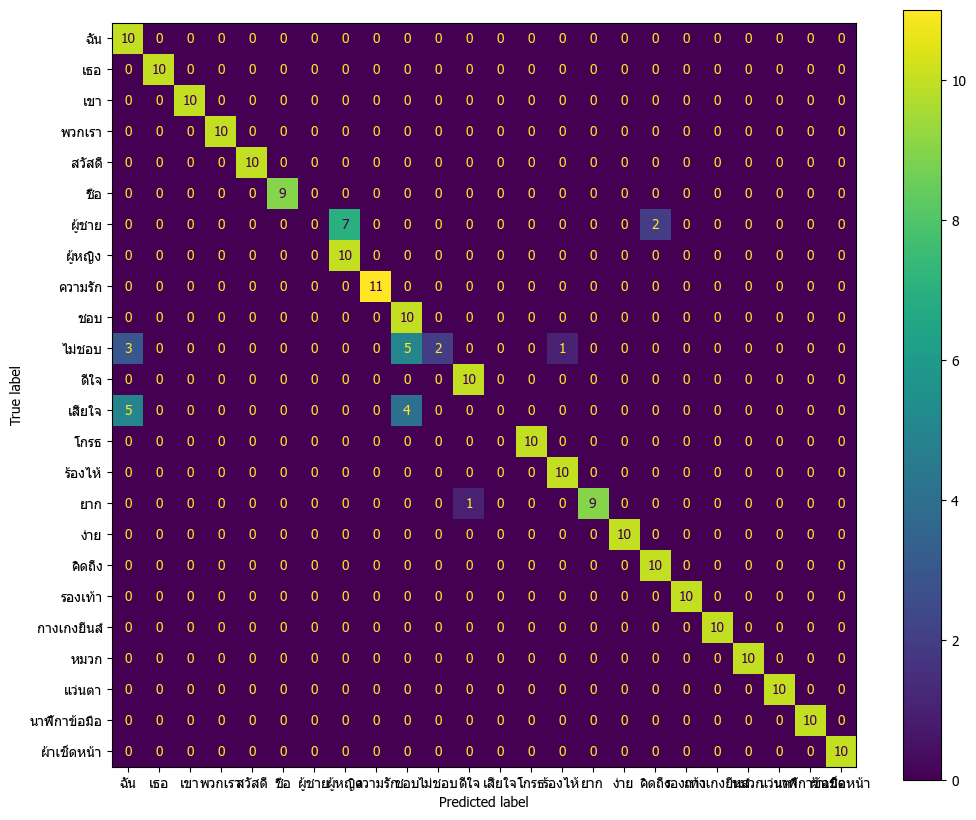

In [83]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


plt.rcParams['font.family'] = 'tahoma'
plt.rcParams['figure.figsize'] = (12, 10)

M = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=class_list)

disp.plot()
plt.show()

In [84]:
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

y_test = []
pred = []
model.eval()
for batch in tqdm(test_dataloader):
    x, y = batch
    y_pred = model(x)
    y_test.extend(y.tolist())
    pred.extend(y_pred.argmax(dim=1).tolist())

print(classification_report(y_test, pred, target_names=class_list))

100%|██████████| 60/60 [00:03<00:00, 17.94it/s]

              precision    recall  f1-score   support

         ฉัน       0.33      0.67      0.44         3
         เธอ       1.00      0.67      0.80         3
         เขา       0.75      1.00      0.86         3
      พวกเรา       0.67      1.00      0.80         2
      สวัสดี       1.00      1.00      1.00         2
        ชื่อ       1.00      1.00      1.00         3
      ผู้ชาย       0.00      0.00      0.00         3
     ผู้หญิง       0.43      1.00      0.60         3
     ความรัก       1.00      1.00      1.00         3
         ชอบ       0.50      1.00      0.67         2
      ไม่ชอบ       0.00      0.00      0.00         3
        ดีใจ       1.00      1.00      1.00         2
      เสียใจ       0.00      0.00      0.00         3
        โกรธ       1.00      1.00      1.00         2
     ร้องไห้       1.00      1.00      1.00         2
         ยาก       1.00      1.00      1.00         2
        ง่าย       1.00      1.00      1.00         2
      คิดถึง       1.00    


c:\Users\pray_\miniconda3\envs\comvision-project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pray_\miniconda3\envs\comvision-project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pray_\miniconda3\envs\comvision-project\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

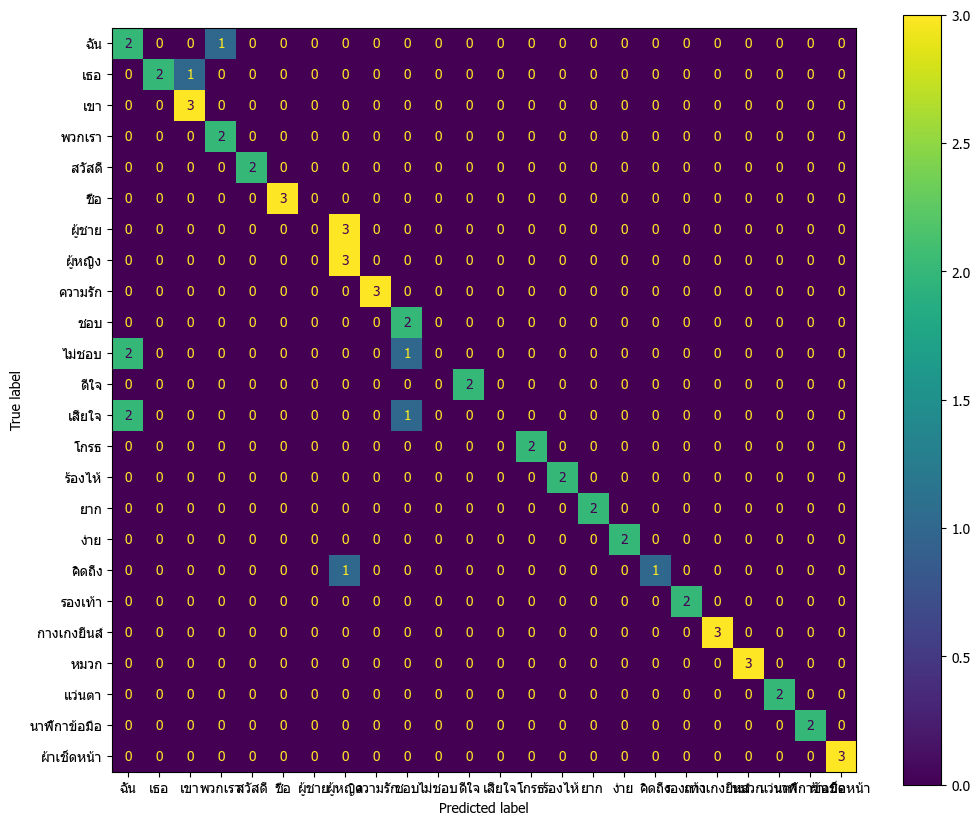

In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


plt.rcParams['font.family'] = 'tahoma'
plt.rcParams['figure.figsize'] = (12, 10)

M = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=class_list)

disp.plot()
plt.show()

# Notebook cam test

In [39]:
model = SimpleLSTM(input_dim=len(col_name), hidden_dim=256, classes=len(ctol))
# model.load_state_dict(torch.load('./checkpoint/model_epoch_95.pt'))
model.load_state_dict(torch.load('./.checkpoints/model_with_remove_non_val/model_epoch_105.pt'))
model.to(device)

SimpleLSTM(
  (lstm1): LSTM(50, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=256, out_features=24, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [41]:
class_list = []
for i in range(len(ctol)):
    class_list.append(ctol[i+1])

In [97]:
data_path = './.checkpoints/test_video/test_kp/'
files = listdir(data_path)
files = [f for f in files if f.endswith('.csv') and 'normalized' not in f]

In [98]:
files

['กางเกงยีนส์.csv', 'ชอบ.csv', 'ร้องไห้.csv', 'สวัสดี.csv']

In [102]:
# test_dataset = LandmarksDataset(data_path='./test_kp/', file_names=files, col_name=col_name, ltoc=ltoc, preprocess_func=preprocess_data, sample_func=sample_data, len_sample=30)
test_dataset = LandmarksDataset(data_path='./.checkpoints/test_video/test_kp/', file_names=files, col_name=col_name, ltoc=ltoc, preprocess_func=preprocess_data_remove_null, sample_func=sample_data_with_trim, len_sample=30, col_name_not_none=hand_col_name)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [104]:
from tqdm import tqdm

model.eval()
for batch in tqdm(test_dataloader):
    x, y = batch
    y_pred = model(x)
    print(f'label: {ctol[y.item()+1]}, pred: {ctol[y_pred.argmax(dim=1).item()+1]}')

100%|██████████| 4/4 [00:00<00:00, 22.80it/s]

label: กางเกงยีนส์, pred: กางเกงยีนส์
label: ชอบ, pred: ชอบ
label: ร้องไห้, pred: ร้องไห้
label: สวัสดี, pred: สวัสดี


# New videos test

In [42]:
model = SimpleLSTM(input_dim=len(col_name), hidden_dim=256, classes=len(ctol))
# model.load_state_dict(torch.load('./checkpoint/model_epoch_95.pt'))
model.load_state_dict(torch.load('./.checkpoints/model_with_remove_non_val/model_epoch_105.pt'))
model.to(device)

SimpleLSTM(
  (lstm1): LSTM(50, 256, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=256, out_features=24, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [43]:
class_list = []
for i in range(len(ctol)):
    class_list.append(ctol[i+1])

In [44]:
data_path = './.checkpoints/new_test_vid/'
files = listdir(data_path)
files = [f for f in files if f.endswith('.csv') and 'normalized' not in f]

In [45]:
files

['ความรัก_15.csv',
 'คิดถึง_13.csv',
 'ชอบ_13.csv',
 'ดีใจ_13.csv',
 'นาฬิกาข้อมือ_13.csv',
 'ผ้าเช็ดหน้า_14.csv',
 'รองเท้า_13.csv',
 'เสียใจ_13.csv',
 'แว่นตา_13.csv',
 'ไม่ชอบ_15.csv']

In [46]:
# test_dataset = LandmarksDataset(data_path='./test_kp/', file_names=files, col_name=col_name, ltoc=ltoc, preprocess_func=preprocess_data, sample_func=sample_data, len_sample=30)
test_dataset = LandmarksDataset(data_path=data_path, file_names=files, col_name=col_name, ltoc=ltoc, preprocess_func=preprocess_data_remove_null, sample_func=sample_data_with_trim, len_sample=30, col_name_not_none=hand_col_name)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [47]:
from tqdm import tqdm

model.eval()
for batch in tqdm(test_dataloader):
    x, y = batch
    y_pred = model(x)
    print(f'label: {ctol[y.item()+1]}, pred: {ctol[y_pred.argmax(dim=1).item()+1]}')

 30%|███       | 3/10 [00:00<00:01,  6.79it/s]

label: ความรัก, pred: ความรัก
label: รองเท้า, pred: รองเท้า
label: แว่นตา, pred: แว่นตา
label: ดีใจ, pred: ดีใจ


 70%|███████   | 7/10 [00:00<00:00, 11.75it/s]

label: เสียใจ, pred: ฉัน
label: นาฬิกาข้อมือ, pred: นาฬิกาข้อมือ
label: ชอบ, pred: ฉัน


100%|██████████| 10/10 [00:00<00:00, 10.31it/s]

label: ผ้าเช็ดหน้า, pred: พวกเรา
label: คิดถึง, pred: ผู้หญิง
label: ไม่ชอบ, pred: ชอบ
